# Import packages

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
import os
from sklearn.model_selection import train_test_split

# Data loading

In [3]:
"""
from google.colab import drive
drive.mount('/content/drive/')
train_directory = '/content/drive/My Drive/Data/seg_train/seg_train'
test_directory = '/content/drive/My Drive/Data/seg_test'
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive/')\n"

In [4]:
train_directory = '/kaggle/input/final-project/Data/seg_train/seg_train'

test_directory = '/kaggle/input/final-project/Data/seg_test'

# Data Augmentation and Preprocessing

In [5]:
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

img_height, img_width = 224, 224
batch_size = 64

data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.Resizing(img_height, img_width)
])

def preprocess_test_img(img, label):
    img = tf.cast(img, tf.float32)
    label = tf.one_hot(label, depth=len(class_names))
    return img, label

def extract_loc(directory):
    file_loc = []
    labels = []

    class_names = [i for i in sorted(os.listdir(directory)) if not i.startswith(".") and os.path.isdir(os.path.join(directory, i))]
    for i, j in enumerate(class_names):
        class_loc = os.path.join(directory, j)
        for k in os.listdir(class_loc):
            if not k.startswith("."):
                file_loc.append(os.path.join(class_loc, k))
                labels.append(i)
    return file_loc, labels, class_names

file_loc, labels, class_names = extract_loc(train_directory)

train_loc, val_loc, train_labels, val_labels = train_test_split(file_loc, labels, test_size=0.2, stratify=labels, random_state=42)

def gen_data(file_loc, labels, batch_size, augment=False):
    section = tf.data.Dataset.from_tensor_slices((file_loc, labels))
    def process_img(file_path, label):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (img_height, img_width))
        if augment:
            img = data_augment(img)
        return img, tf.one_hot(label, depth=len(class_names))

    return section.map(process_img).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = gen_data(train_loc, train_labels, batch_size, augment=True)
val_data = gen_data(val_loc, val_labels, batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
).map(preprocess_test_img).prefetch(buffer_size=tf.data.AUTOTUNE)


Found 3000 files belonging to 6 classes.


# Model Building

In [6]:
#https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
#https://keras.io/api/layers/regularizers/

def build_model(base_model):
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(len(class_names), activation='softmax')
    ])
    return model

In [7]:
#https://keras.io/api/applications/resnet/
#https://keras.io/api/applications/efficientnet/
#https://keras.io/api/applications/vgg/

base_models = {
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)),
    "ResNet101": ResNet101(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)),
    "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
}

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Model Training and Evaluation

In [19]:
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
#https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LRScheduler.html
#https://keras.io/api/callbacks/model_checkpoint/

def train_plot_model(model_name, base_model, train_data, val_data, test_data, class_names):

    model = build_model(base_model)

    LRscheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=650,
    decay_rate=0.9
    )

    model.compile(
        optimizer=Adam(learning_rate=LRscheduler),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    )
    checkpoint_path = f"checkpoints/{model_name}_best_model.keras"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        monitor="val_loss",
        mode="min"
    )
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=50,
        callbacks=[checkpoint,early_stopping]
    )

    if os.path.exists(checkpoint_path):
        print("Loading best weights for:" ,model_name)
        model.load_weights(checkpoint_path)
    else:
        print("Skipping weight loading")


    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    test_loss, test_acc = model.evaluate(test_data)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_acc)

    model.save(f"{model_name}.keras")

    evaluate_model(model, train_data, "Train", class_names)
    evaluate_model(model, val_data, "Validation", class_names)
    evaluate_model(model, test_data, "Test", class_names)

    return model

In [20]:
#https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.OneHotEncoder.html

def evaluate_model(model, dataset, dataset_name, class_names):
    print("\nEvaluating",dataset_name)

    y_actual = np.concatenate([y.numpy() for _, y in dataset], axis=0)

    if y_actual.ndim > 1 and y_actual.shape[1] > 1:
        y_actual = np.argmax(y_actual, axis=1)

    y_vals = []
    y_predicted = []

    for i, _ in dataset:
        op = model.predict(i)
        y_vals.append(op)
        y_predicted.append(np.argmax(op, axis=1))

    y_predicted = np.concatenate(y_predicted, axis=0)
    y_vals = np.concatenate(y_vals, axis=0)

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    y_actual_onehot = encoder.fit_transform(y_actual.reshape(-1, 1))

    print("\nClassification Report for ",dataset_name,":\n")
    print(classification_report(y_actual, y_predicted, target_names=class_names))
    print(dataset_name,"AUC:",roc_auc_score(y_actual_onehot, y_vals, multi_class='ovr'))

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.7523 - loss: 4.2122 - val_accuracy: 0.8782 - val_loss: 1.4820
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.8455 - loss: 1.2775 - val_accuracy: 0.8696 - val_loss: 0.7483
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.8482 - loss: 0.7529 - val_accuracy: 0.8685 - val_loss: 0.6288
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.8579 - loss: 0.6423 - val_accuracy: 0.8831 - val_loss: 0.5573
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.8553 - loss: 0.6119 - val_accuracy: 0.8767 - val_loss: 0.5608
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.8550 - loss: 0.6066 - val_accuracy: 0.8803 - val_loss: 0.5490
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.8591 - loss: 0.5948 - val_accuracy: 0.8764 - val_loss: 0.5401
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.8643 - loss: 0.5754 - val_accu

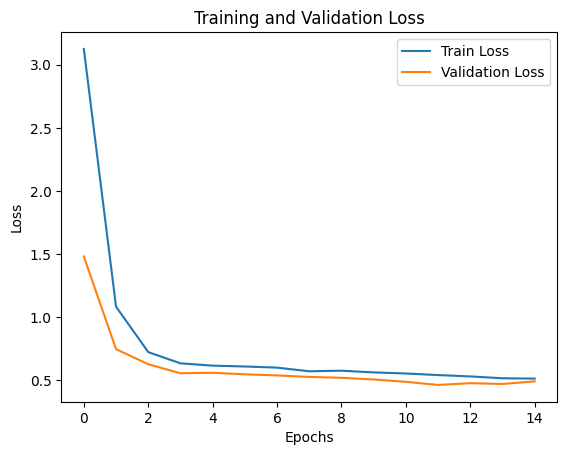

47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.9070 - loss: 0.4310
Test Loss: 0.47676753997802734
Test Accuracy: 0.8856666684150696

Evaluating Train
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━

<Sequential name=sequential_5, built=True>

In [21]:
train_plot_model("ResNet50", base_models["ResNet50"], train_data, val_data, test_data, class_names)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.7539 - loss: 4.2236 - val_accuracy: 0.8700 - val_loss: 1.5337
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.8503 - loss: 1.3178 - val_accuracy: 0.8807 - val_loss: 0.7478
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.8407 - loss: 0.7842 - val_accuracy: 0.8831 - val_loss: 0.5980
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.8511 - loss: 0.6577 - val_accuracy: 0.8824 - val_loss: 0.5623
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.8455 - loss: 0.6472 - val_accuracy: 0.8839 - val_loss: 0.5536
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.8563 - loss: 0.6069 - val_accuracy: 0.8725 - val_loss: 0.5497
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.8576 - loss: 0.6033 - val_accuracy: 0.8689 - val_loss: 0.5553
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.8556 - loss: 0.5952 - val_accu

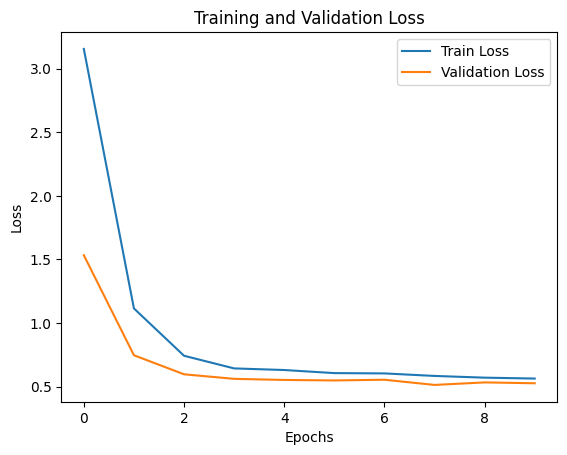

47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step - accuracy: 0.8936 - loss: 0.4728
Test Loss: 0.5211134552955627
Test Accuracy: 0.8756666779518127

Evaluating Train
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━

<Sequential name=sequential_4, built=True>

In [18]:
train_plot_model("ResNet101", base_models["ResNet101"], train_data, val_data, test_data, class_names)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.7649 - loss: 3.9252 - val_accuracy: 0.8846 - val_loss: 1.3997
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8551 - loss: 1.1709 - val_accuracy: 0.8874 - val_loss: 0.6430
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8581 - loss: 0.6710 - val_accuracy: 0.8942 - val_loss: 0.5065
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8621 - loss: 0.5734 - val_accuracy: 0.8978 - val_loss: 0.4604
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8637 - loss: 0.5314 - val_accuracy: 0.9059 - val_loss: 0.4281
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8695 - loss: 0.5162 - val_accuracy: 0.9059 - val_loss: 0.4247
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8678 - loss: 0.5230 - val_accuracy: 0.9049 - val_loss: 0.4271
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8728 - loss: 0.5146 - val_accu

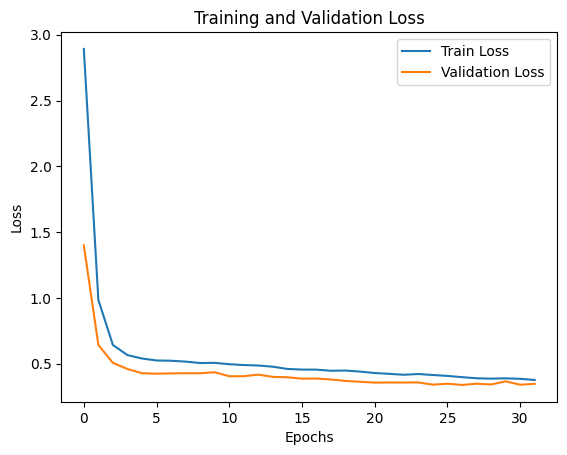

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9042 - loss: 0.3591
Test Loss: 0.34922313690185547
Test Accuracy: 0.9086666703224182

Evaluating Train
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━

<Sequential name=sequential_4, built=True>

In [20]:
train_plot_model("EfficientNetB0", base_models["EfficientNetB0"], train_data, val_data, test_data, class_names)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.6938 - loss: 3.4890 - val_accuracy: 0.8443 - val_loss: 1.3902
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8121 - loss: 1.2469 - val_accuracy: 0.8575 - val_loss: 0.7136
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.8173 - loss: 0.7658 - val_accuracy: 0.8379 - val_loss: 0.5975
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.8214 - loss: 0.6354 - val_accuracy: 0.8589 - val_loss: 0.5180
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.8180 - loss: 0.5932 - val_accuracy: 0.8397 - val_loss: 0.5252
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.8182 - loss: 0.5999 - val_accuracy: 0.8643 - val_loss: 0.4933
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8247 - loss: 0.5772 - val_accuracy: 0.8643 - val_loss: 0.4926
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.8247 - loss: 0.5759 - val_accu

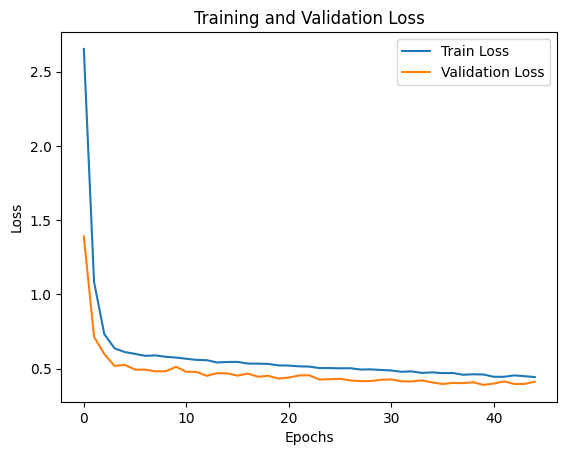

47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 922ms/step - accuracy: 0.8754 - loss: 0.3988
Test Loss: 0.39401569962501526
Test Accuracy: 0.8833333253860474

Evaluating Train
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━

<Sequential name=sequential_5, built=True>

In [21]:
train_plot_model("VGG16", base_models["VGG16"], train_data, val_data, test_data, class_names)

EfficientNetB0 is the best model with test accuracy 0.91